# RRT Path planning

In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib widget

## Tree Class

In [2]:
class Tree:
    """
    Tree
    """
    def __init__(self):
        self.vertices = []
        self.edges = []

    def add_vertex(self, point):
        self.vertices.append(point)

    def add_edge(self, point_idx):
        self.edges.append(point_idx)

## Environment Class

In [3]:
class Environment:
    """
    Environment (Map, Obstacles)
    """
    def __init__(
        self, 
        x_min, 
        y_min, 
        z_min,
        x_max, 
        y_max,
        z_max
    ):
        self.x_min = x_min
        self.y_min = y_min
        self.z_min = z_min
        self.x_max = x_max
        self.y_max = y_max
        self.z_max = z_max
        self.obstacles = []

    def add_obstacle(self, obj):
        self.obstacles.extend(obj)

## RRT Class

In [4]:
class RRT:
    """
    RRT path planning
    """
    def __init__(
        self, 
        env,
        start, 
        goal,
        delta_distance=1,
        epsilon = 0.1,
        max_iter=1000, 
    ):
        self.env = env
        self.start = start
        self.goal  = goal
        self.delta_dis = delta_distance
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.T = Tree()

    def generate_path(self):
        path = None
        self.T.add_vertex(self.start)
        for k in range(self.max_iter):
            rand_point = self.random_state()
            near_point, near_idx = self.nearest_neighbor(rand_point, self.T)
            new_point  = self.new_state(near_point, rand_point)

            if self.collision_free(near_point, new_point):
                self.T.add_vertex(new_point)
                new_idx = len(self.T.vertices) - 1
                self.T.add_edge([near_idx, new_idx])

                if self.reach_to_goal(new_point):
                    print("reached to the goal")
                    path = self.find_path(self.T)
                    break
        return path

    def random_state(self):
        if np.random.random() > self.epsilon:
            point = np.array([np.random.uniform(self.env.x_min, self.env.x_max),
                              np.random.uniform(self.env.y_min, self.env.y_max),
                              np.random.uniform(self.env.z_min, self.env.z_max)]) 
        else:
            point = self.goal
        return point

    def nearest_neighbor(self, random_point, tree):
        distances = [self.distance(random_point, point) 
                     for point in tree.vertices]
        nearest_idx = np.argmin(distances)
        nearest_point = tree.vertices[nearest_idx]
        return nearest_point, nearest_idx

    def distance(self, pointA, pointB):
        return np.linalg.norm(pointB - pointA)

    def new_state(self, nearest_point, random_point):
        if np.equal(nearest_point, random_point).all():
            return nearest_point

        vector = random_point - nearest_point
        dist = self.distance(random_point, nearest_point)
        step = min(self.delta_dis, dist)
        unit_vector = vector / dist
        new_point = nearest_point + unit_vector * step

        return new_point

    def collision_free(self, pointA, pointB):
        for (obs_x, obs_y, obs_z, obs_r) in self.env.obstacles:
            if self.is_inside_circle(obs_x, obs_y, obs_z, obs_r, pointB):
                return False
            if self.is_intersect_circle(obs_x, obs_y, obs_z, obs_r, pointA, pointB):
                return False
        return True

    def is_inside_circle(self, x, y, z, r, point):
        obs_point = np.array([x, y, z])
        distances = self.distance(point, obs_point)
        if distances <= r + self.delta_dis:
            return True
        return False

    def is_intersect_circle(self, x, y, z, r, pointA, pointB):
        vectorAB = pointB - pointA
        distanceAB = self.distance(pointB, pointA)
        if distanceAB == 0:
            return False

        pointC = np.array([x, y, z])
        vectorAC = pointC - pointA
        proj = np.dot(vectorAC, vectorAB) / distanceAB
        proj = np.clip(proj, 0, 1)

        pointD = pointA + proj * vectorAB
        distancCD = self.distance(pointD, pointC)
        
        if distancCD <= r + self.delta_dis:
            return True
        return False

    def reach_to_goal(self, point):
        dist = self.distance(point, self.goal)
        if dist <= 0.5:
            return True
        return False

    def find_path(self, tree):
        path = [self.goal]
        goal_idx = tree.edges[-1][1]
 
        while goal_idx != 0:
            path.append(tree.vertices[goal_idx])
            parent_idx = tree.edges[goal_idx-1][0]
            goal_idx = parent_idx
        path.append(self.start)

        return path[::-1]

    def get_rrt_tree(self):
        vertices = []
        for edge in self.T.edges:
            from_node = self.T.vertices[edge[0]]
            goal_node = self.T.vertices[edge[1]]
            vertices.append((from_node, goal_node))
        return vertices

In [5]:
def init_3d_figure(name=None):
    """
    Initializes 3d figure
    """
    fig = plt.figure(name)
    ax = fig.add_subplot(111, projection='3d')
    return fig, ax


def plot_sphere(ax=None, radius=1.0, p=np.zeros(3), n_steps=20, alpha=1.0, color="k"):
    """
    Plot sphere
    """
    phi, theta = np.mgrid[0.0:np.pi:n_steps * 1j, 0.0:2.0 * np.pi:n_steps * 1j]
    x = p[0] + radius * np.sin(phi) * np.cos(theta)
    y = p[1] + radius * np.sin(phi) * np.sin(theta)
    z = p[2] + radius * np.cos(phi)

    ax.plot_surface(x, y, z, color=color, alpha=alpha, linewidth=0)

reached to the goal


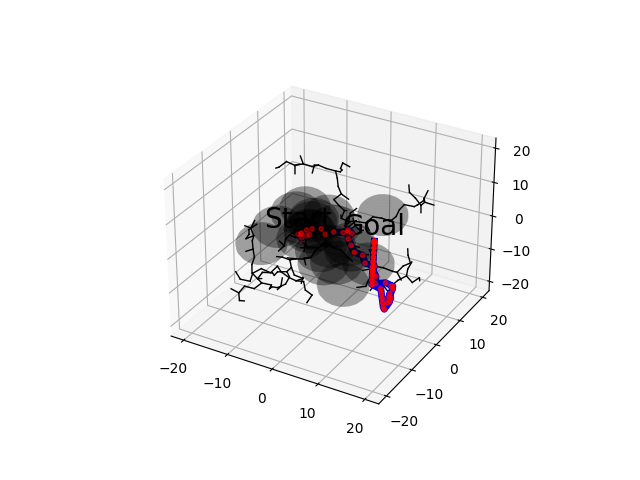

In [6]:


fig, ax = init_3d_figure("Test")    
env = Environment(x_min=-20, y_min=-20, z_min=-20, x_max=20, y_max=20, z_max=20)

spheres = []
radius = 5
for i in range(20):
    x = random.choice([i for i in range(-10, 10)])
    y = random.choice([i for i in range(-10, 10)])
    z = random.choice([i for i in range(-10, 10)])
    spheres.append((x, y, z, radius))
env.add_obstacle(spheres)


start_point = np.array([-20, 20, -20])
goal_point  = np.array([20, -20, 20])

planner = RRT( env, 
                    start=start_point, 
                    goal=goal_point, 
                    delta_distance=2,
                    epsilon=0.2, 
                    max_iter=500)

path = planner.generate_path()
tree = planner.get_rrt_tree()

# Plot
for sp_x, sp_y, sp_z, sp_r in spheres:
    sp_radius = sp_r
    sp_pos = np.array([sp_x, sp_y, sp_z])
    plot_sphere(ax, radius=radius, p=sp_pos, alpha=0.2, color="k")

for vertex in tree:
    ax.plot([x for (x, y, z) in vertex],[y for (x, y, z) in vertex], [z for (x, y, z) in vertex],'k', linewidth=1,)

if path is None:
    print("cannot create path")
else:
    ax.scatter([x for (x, y, z) in path], [y for (x, y, z) in path], [z for (x, y, z) in path], s=10, c='r')
    ax.plot([x for (x, y, z) in path], [y for (x, y, z) in path], [z for (x, y, z) in path], '-b', linewidth=5,)
    ax.text(path[0][0], path[0][1], path[0][2], 'Start', verticalalignment='bottom', horizontalalignment='center', size="20")
    ax.text(path[-1][0], path[-1][1], path[-1][2],'Goal', verticalalignment='bottom', horizontalalignment='center', size="20")
plt.show()